# Machine Learning estimation for std properties

Based on the Molar Mass, State of Matter, and Charge, we now create machine learning models to predict the standard free Gibbs energy of formation, enthalpy, entropy, and heat capacities.

## Required dependencies

In [1]:
import pandas as pd

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor

from pathlib import Path
import os

DATA_PATH = Path(os.environ.get("DATAPATH"))
sklearn.set_config(transform_output="pandas")

## Read preprocessed data

In [2]:
df_nist_stdprops = pd.read_csv(DATA_PATH / "NBS_Tables_preprocessed.csv", index_col=0)

df_nist_stdprops

,Formula,State,Molar Mass,deltaH0,deltaG0,S0,Cp,Charge
0,O,g,15.9994,249.170,231.731,161.055,21.912,0.0
1,O2,g,31.9988,0.000,0.000,205.138,29.355,0.0
2,O3,g,47.9982,142.700,163.200,238.930,39.200,0.0
3,H,g,1.0080,217.965,203.247,114.713,20.784,0.0
4,H<sup>+</sup>,ao,1.0080,0.000,0.000,0.000,0.000,1.0
...,...,...,...,...,...,...,...,...
1515,CsBO2,g,175.7152,-703.300,-708.800,314.410,59.410,0.0
1516,CsAl(SO4)2·12H2O,cr,568.1949,-6094.800,-5167.400,686.090,614.600,0.0
1517,CsCuCl3,cr,302.8044,-698.700,-627.100,213.380,127.820,0.0
1518,Cs2Cr2O7,cr,481.7986,-2088.820,-1908.170,330.080,231.540,0.0


## Organizing the data

Separating features and targets:

In [3]:
features_columns = ["Molar Mass", "Charge"]
target_columns = ["deltaH0", "deltaG0", "S0", "Cp"]

X = df_nist_stdprops[features_columns]
y = df_nist_stdprops[target_columns]

Splitting the data:

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [5]:
X_train

,Molar Mass,Charge
1423,174.2656,0.0
1083,203.3104,0.0
1435,180.0372,0.0
111,62.0049,-1.0
1295,54.9886,0.0
...,...,...
1130,145.1493,0.0
1294,38.9892,0.0
860,107.9034,0.0
1459,486.0120,0.0


In [6]:
y_train

,deltaH0,deltaG0,S0,Cp
1423,-1437.79,-1321.37,175.56,131.46
1083,-2499.02,-2114.64,366.10,315.06
1435,-1180.70,-1035.90,155.02,126.73
111,-207.36,-111.25,146.40,-86.60
1295,-260.20,-218.40,115.90,72.13
...,...,...,...,...
1130,-1574.65,-1435.78,134.30,124.22
1294,105.00,82.40,228.60,34.70
860,-138.00,-163.00,231.82,33.14
1459,-1229.30,-1078.50,333.90,205.60


## Data scaling

In [7]:
scaler = StandardScaler()  
scaler.fit(X_train)
X_train_rescaled = scaler.transform(X_train)  
X_test_rescaled = scaler.transform(X_test)  

In [8]:
X_train_rescaled

,Molar Mass,Charge
1423,0.012310,-0.067642
1083,0.204875,-0.067642
1435,0.050575,-0.067642
111,-0.731971,-3.494858
1295,-0.778489,-0.067642
...,...,...
1130,-0.180729,-0.067642
1294,-0.884564,-0.067642
860,-0.427667,-0.067642
1459,2.079169,-0.067642


## Build the machine learning model (Neural Network, in this case)

Initialize the Multilayer Percepton with ADAM:

In [9]:
regr = MLPRegressor(	
    solver='adam',
    learning_rate='adaptive',
    hidden_layer_sizes=(10, 20, 20, 10),  # 10:20:20:10 architecture
    random_state=1, 
    max_iter=10000,  # 10k epochs
    tol=1e-5,
    n_iter_no_change=1000,
    early_stopping=True
)

Run training:

In [10]:
regr.fit(X_train_rescaled, y_train)

MLPRegressor(early_stopping=True, hidden_layer_sizes=(10, 20, 20, 10),
             learning_rate='adaptive', max_iter=10000, n_iter_no_change=1000,
             random_state=1, tol=1e-05)

Run predictions:

In [11]:
y_predict = regr.predict(X_test_rescaled)

In [12]:
y_predict

array([[-679.34383629, -616.44914973,  185.46262195,   76.6631843 ],
       [-212.87695072, -192.69580667,  145.63100524,   40.24240542],
       [-570.769283  , -517.76694546,  179.61885125,   68.7710221 ],
       ...,
       [-661.86667268, -600.50091373,  184.17384584,   75.35516384],
       [-166.71872472, -150.5355498 ,  139.2601702 ,   36.39906915],
       [-351.94972221, -320.68236309,  208.26032077,   60.92891452]])

In [13]:
dict_y_predict = {}
for id_target, target in enumerate(list(y_train.columns)):
    dict_y_predict[target] = y_predict[:, id_target]
    
df_y_predict = pd.DataFrame.from_dict(dict_y_predict)

df_y_predict

,deltaH0,deltaG0,S0,Cp
0,-679.343836,-616.449150,185.462622,76.663184
1,-212.876951,-192.695807,145.631005,40.242405
2,-570.769283,-517.766945,179.618851,68.771022
3,-1499.717032,-1363.140435,240.917643,138.287665
4,-1499.459404,-1362.908669,240.906272,138.267946
...,...,...,...,...
299,-180.377125,-163.172526,141.932967,37.576284
300,-269.715127,-244.169425,151.323652,44.865818
301,-661.866673,-600.500914,184.173846,75.355164
302,-166.718725,-150.535550,139.260170,36.399069


Check the score:

In [14]:
regr.score(X_test_rescaled, y_test)

-0.23519203984796253

## Assess the results

In [15]:
import matplotlib.pyplot as plt

Check `deltaH0` results:

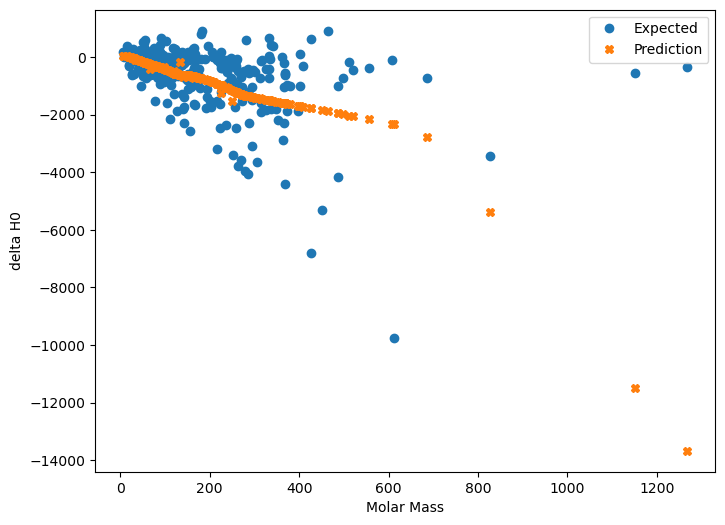

In [16]:
plt.figure(figsize=(8, 6))

plt.plot(X_test["Molar Mass"], y_test["deltaH0"], 'o', label="Expected")
plt.plot(X_test["Molar Mass"], df_y_predict["deltaH0"], 'X', label="Prediction")

plt.xlabel("Molar Mass")
plt.ylabel("delta H0")

plt.legend()

plt.show()

Check `deltaG0` results:

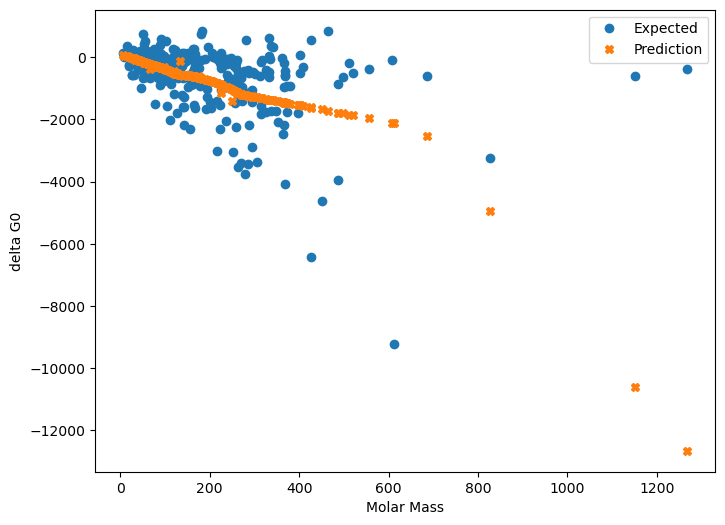

In [17]:
plt.figure(figsize=(8, 6))

plt.plot(X_test["Molar Mass"], y_test["deltaG0"], 'o', label="Expected")
plt.plot(X_test["Molar Mass"], df_y_predict["deltaG0"], 'X', label="Prediction")

plt.xlabel("Molar Mass")
plt.ylabel("delta G0")

plt.legend()

plt.show()

Check `S0` results:

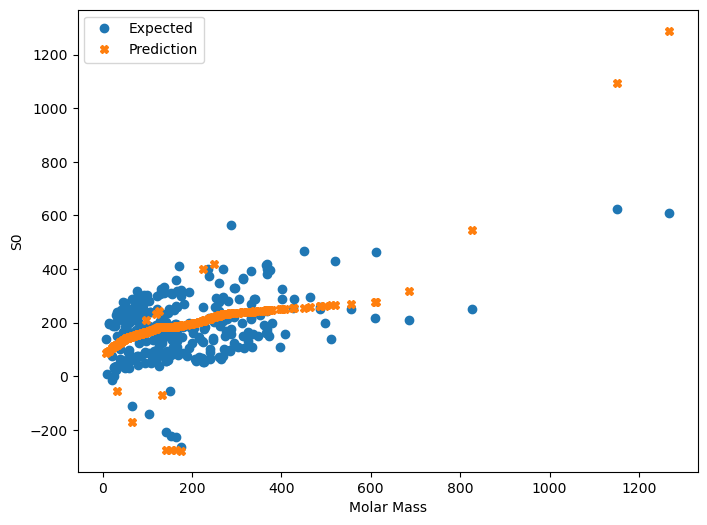

In [18]:
plt.figure(figsize=(8, 6))

plt.plot(X_test["Molar Mass"], y_test["S0"], 'o', label="Expected")
plt.plot(X_test["Molar Mass"], df_y_predict["S0"], 'X', label="Prediction")

plt.xlabel("Molar Mass")
plt.ylabel("S0")

plt.legend()

plt.show()

Check `Cp` results:

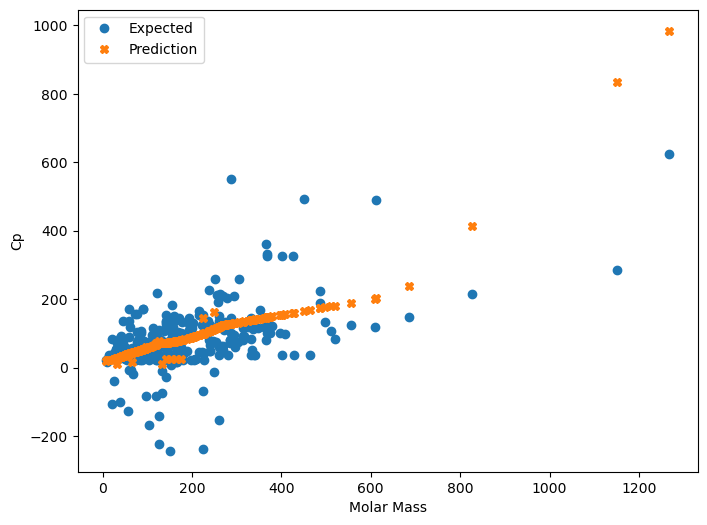

In [19]:
plt.figure(figsize=(8, 6))

plt.plot(X_test["Molar Mass"], y_test["Cp"], 'o', label="Expected")
plt.plot(X_test["Molar Mass"], df_y_predict["Cp"], 'X', label="Prediction")

plt.xlabel("Molar Mass")
plt.ylabel("Cp")

plt.legend()

plt.show()